## Importing Libreries

In [170]:
import cv2
import numpy as np
import imageio as iio
from matplotlib import pyplot as plt

### Loading the image

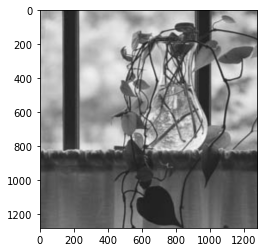

In [171]:
img = cv2.imread("Q5.png")
plt.imshow(img);

### Making noisy image

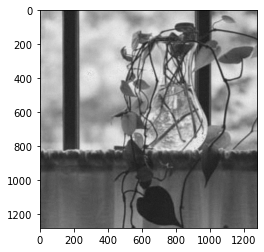

In [190]:
mu, sigma = 0, 10 # mean and standard deviation
noise = np.random.normal(mu, sigma, size=(img.shape[0:2])).astype("uint8")
noise = np.dstack((noise,noise,noise))
img_noisy = img.copy() + noise
img_noisy = (img_noisy-np.min(img_noisy))/(np.max(img_noisy)-np.min(img_noisy))*255
img_noisy = img_noisy.astype("uint8")
plt.imshow(img_noisy);

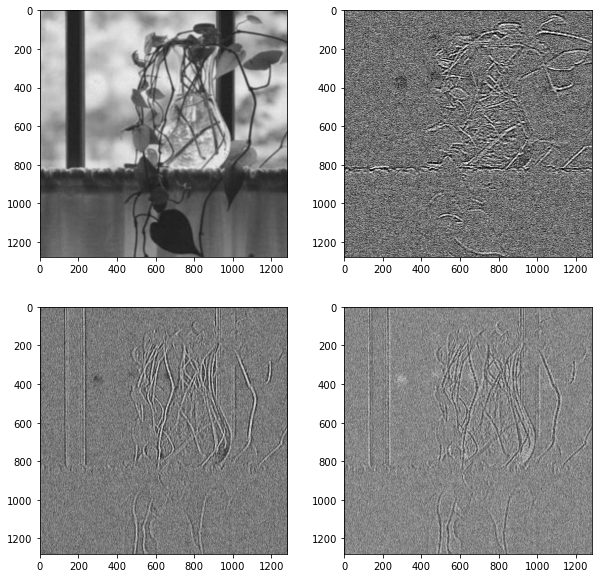

In [191]:
def my_wavelet(img,sigma=1,k=21):
    L = cv2.GaussianBlur(img,ksize=(k,1),sigmaX=sigma,sigmaY=0)
    H = img-L
    
    LL = cv2.GaussianBlur(L,ksize=(1,k),sigmaX=0,sigmaY=sigma)
    LH = L - LL
    
    HL = cv2.GaussianBlur(H,ksize=(1,k),sigmaX=0,sigmaY=sigma)
    HH = H - HL
    
    return (LL,LH, HL,HH)
plt.figure(figsize=(10,10))
s = 2
k = 77
plt.subplot(221)
plt.imshow(my_wavelet(img_noisy,k=k,sigma=s)[0]);
plt.subplot(222)
plt.imshow(my_wavelet(img_noisy,k=k,sigma=s)[1]);
plt.subplot(223)
plt.imshow(my_wavelet(img_noisy,k=k,sigma=s)[2]);
plt.subplot(224)
plt.imshow(my_wavelet(img_noisy,k=k,sigma=s)[3]);

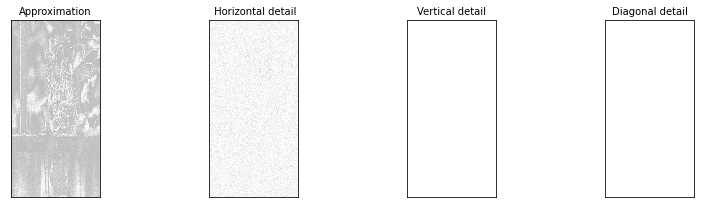

In [174]:
import pywt
import pywt.data

# Load image
original = img_noisy.copy()

# Wavelet transform of image, and plot approximation and details
titles = ['Approximation', ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']
coeffs2 = pywt.dwt2(original, 'bior1.3')
LL, (LH, HL, HH) = coeffs2
fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([LL, LH, HL, HH]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a.astype("uint8"), interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()